# HSCT survival: XGBoost model

## Notebook set-up

In [ ]:
import pickle
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import configuration as config
import functions.helper as helper_funcs
import functions.plotting as plot_funcs

# Data files
data_df_file=f'{config.DATA_PATH}/processed/02.1-multicollinear_encoded_all_imputed_data_df.parquet'
raw_data_file=f'{config.DATA_PATH}/raw/train.csv'
hyperparameter_tuning_results=f'{config.DATA_PATH}/results/05.2-hyperparameter_tuning_results.parquet'

# Model files
naive_model_file=f'{config.MODELS_PATH}/05.2-XGBoost_naive.pkl'
tuned_model_file=f'{config.MODELS_PATH}/05.2-XGBoost_tuned.pkl'

retune_model=True

## 1. Load data

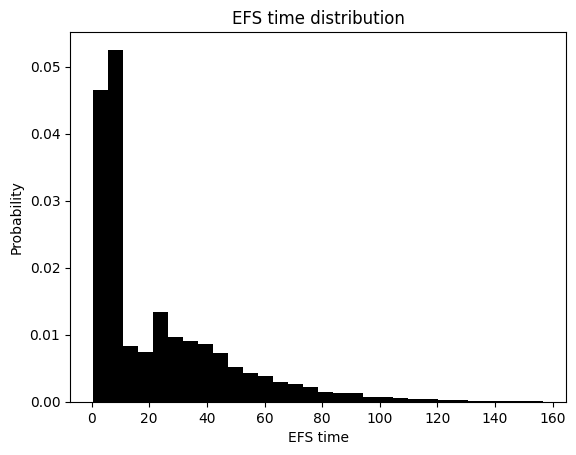

Training features: (28800, 150)


In [2]:
# Load the data
data_df=pd.read_parquet(data_df_file)

# Load and preserve race group for scoring
raw_data=pd.read_csv(raw_data_file)
data_df['race_group']=raw_data['race_group']

# Clean up column names
data_df.columns=data_df.columns.str.replace('[\\[\\]<]', '', regex=True)

# Take a quick look at the target
plt.title('EFS time distribution')
plt.hist(data_df['efs_time'], density=True, bins=30, color='black')
plt.xlabel('EFS time')
plt.ylabel('Probability')
plt.show()

print(f'Training features: {data_df.shape}')

## 2. Data preparation

### 2.1. Train-test split

In [3]:
training, testing=train_test_split(data_df, test_size=0.33, random_state=315)

training_df=pd.DataFrame(training, columns=data_df.columns)
testing_df=pd.DataFrame(testing, columns=data_df.columns)

training_labels_df=training_df[['efs', 'efs_time']]
training_features_df=training_df.drop(['efs', 'efs_time'], axis=1)

testing_labels_df=testing_df[['efs', 'efs_time']]
testing_features_df=testing_df.drop(['efs', 'efs_time'], axis=1)

### 2.2. Save and remove training & testing race group

In [4]:
training_race_group=training_df['race_group']
testing_race_group=testing_df['race_group']

training_df.drop('race_group', axis=1, inplace=True)
testing_df.drop('race_group', axis=1, inplace=True)

### 2.3. Make features and labels

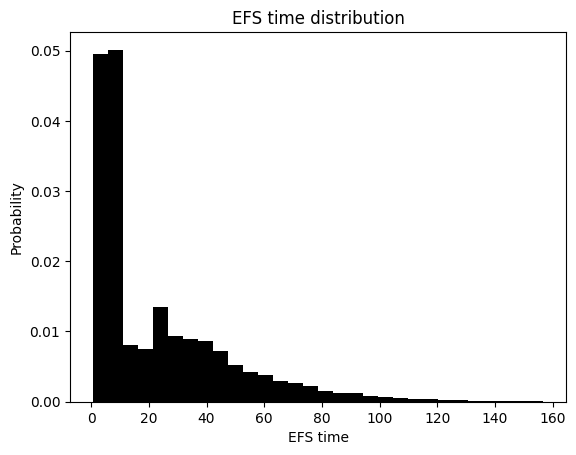

Training features: (19296, 147)
Testing features: (9504, 147)


In [ ]:
training_labels_df=training_df[['efs', 'efs_time']].copy()
training_features_df=training_df.drop(['efs', 'efs_time'], axis=1)
training_labels_df['efs_time']=np.log(training_labels_df['efs_time'])

testing_labels_df=testing_df[['efs', 'efs_time']].copy()
testing_features_df=testing_df.drop(['efs', 'efs_time'], axis=1)
testing_labels_df['efs_time']=np.log(testing_labels_df['efs_time'])

# Take a quick look at the target
plt.title('EFS time distribution')
plt.hist(training_labels_df['efs_time'], density=True, bins=30, color='black')
plt.xlabel('EFS time')
plt.ylabel('Probability')
plt.show()

print(f'Training features: {training_features_df.shape}')
print(f'Testing features: {testing_features_df.shape}')

## 3. Naive model

In [ ]:
# XGBoost Model
xgb_params={
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 315
}

# Train on the complete training set
dtraining=xgb.DMatrix(training_features_df, label=training_labels_df['efs_time'])

naive_model=xgb.train(
    xgb_params,
    dtraining,
    num_boost_round=1000,
    evals=[(dtraining, 'training')],
    early_stopping_rounds=10,
    verbose_eval=0
)

# Save the model
with open(naive_model_file, 'wb') as output_file:
    pickle.dump(naive_model, output_file)

# Make predictions for the test set
dtesting=xgb.DMatrix(testing_features_df, label=testing_labels_df['efs_time'])
naive_predicted_efs_time=naive_model.predict(dtesting)

# Score the predictions
scoring_results={
    'Model': [],
    'RMSE': [],
    'C-index': [],
    'Stratified C-index': []
}

scoring_results=helper_funcs.score_predictions(
    model_description='Naive',
    predictions=naive_predicted_efs_time,
    labels_df=testing_labels_df,
    race_group=testing_race_group,
    results=scoring_results
)

for key, value in scoring_results.items():
    print(f'{key}: {value[0]}')

Model: Naive
RMSE: 9.937953332632077
C-index: 0.8600461175673195
Stratified C-index: 0.4948511176622946


## 4. Hyperparameter tuning

In [8]:
# Train or load model as desired
if retune_model == True:

    # Define the hyperparameter search space
    search_space={
        'objective': ['reg:squarederror'],
        'eval_metric': ['rmse'],
        'seed': [315],
        'learning_rate': [0.001, 0.01, 0.1],
        'max_depth': [2, 4, 8, 16],
        'gamma': [0.01, 0.1, 1],
        #'subsample': [0.3, 0.6, 0.9]
    }

    results_df, tuned_model=helper_funcs.xgb_hyperparameter_search(
        search_space,
        training_df
    )

    # Save the tuned model
    with open(tuned_model_file, 'wb') as output_file:
        pickle.dump(tuned_model, output_file)

    # Save the hyperparameter tuning results
    results_df.to_parquet(hyperparameter_tuning_results)
    
elif retune_model == False:

    # Load the last tuned model
    with open(tuned_model_file, 'rb') as input_file:
        tuned_model=pickle.load(input_file)

    # Load the results from the last tuning run
    results_df=pd.read_parquet(hyperparameter_tuning_results)

Winning hyperparameters: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'seed': 315, 'learning_rate': 0.1, 'max_depth': 4, 'gamma': 0.1}


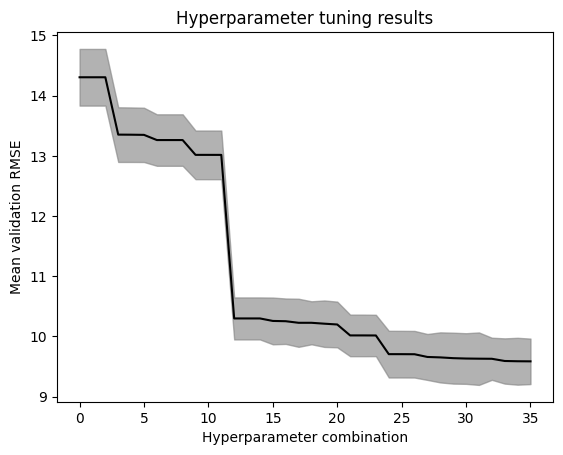

In [9]:
plt.title('Hyperparameter tuning results')
plt.plot(results_df.index, results_df['RMSE mean'], color='black')
plt.fill_between(
    results_df.index,
    results_df['RMSE mean'] - results_df['RMSE standard deviation'],
    results_df['RMSE mean'] + results_df['RMSE standard deviation'],
    color='gray',
    alpha=0.6
)
plt.xlabel('Hyperparameter combination')
plt.ylabel('Mean validation RMSE')
plt.show()

## 5. Evaluate tuned model on test set

In [10]:
# Make predictions on the training set
tuned_predicted_efs_time=tuned_model.predict(dtesting)

scoring_results=helper_funcs.score_predictions(
    model_description='Tuned',
    predictions=tuned_predicted_efs_time,
    labels_df=testing_labels_df,
    race_group=testing_race_group,
    results=scoring_results
)

## 6. Model comparison: test set performance

### 6.1. Scores

In [11]:
scoring_results_df=pd.DataFrame.from_dict(scoring_results)
scoring_results_df.head()

,Model,RMSE,C-index,Stratified C-index
0,Naive,9.937953,0.860046,0.494851
1,Tuned,9.602971,0.871799,0.498528


### 6.2. Performance evaluation plots

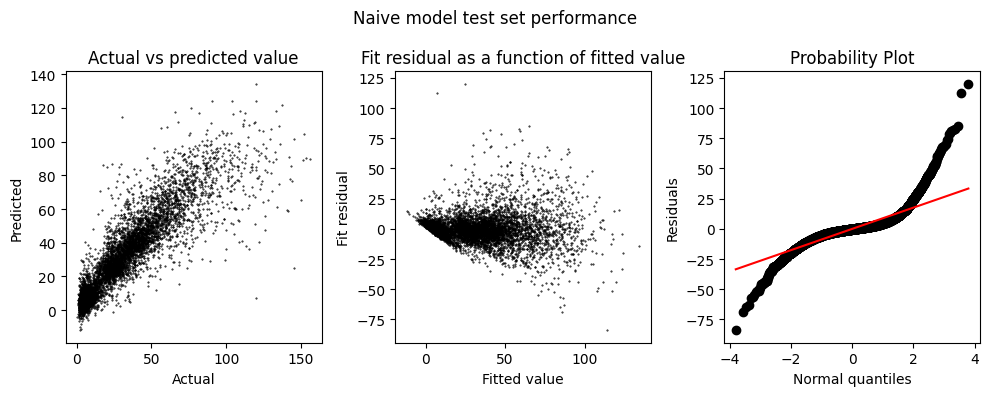

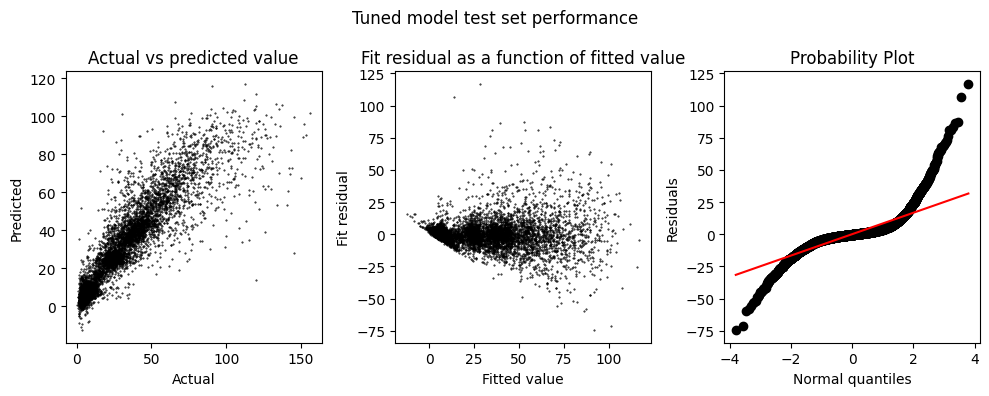

In [12]:
plot_funcs.prediction_eval_plot(
    'Naive model test set performance',
    naive_predicted_efs_time,
    testing_df['efs_time']
).show()

plot_funcs.prediction_eval_plot(
    'Tuned model test set performance',
    tuned_predicted_efs_time,
    testing_df['efs_time']
).show()